In [46]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
import re

import nltk
import time
import gzip
import gensim 
import logging
import warnings

from sklearn.model_selection import train_test_split
#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding,Bidirectional, Dropout,TimeDistributed, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

In [2]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

## Mounting from gDrive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
foldername = "/content/drive/MyDrive/Shopee Code League -Address Elements Extraction/"

## Retrieving Data

In [6]:
#Read csv
trainPath = foldername+"train.csv"
testPath = foldername+"test.csv"
train = pd.read_csv (trainPath)
test = pd.read_csv (testPath)

In [7]:
df_train = pd.DataFrame(train, columns= ['id','raw_address','POI/street'])
print(df_train)

            id  ...                                 POI/street
0            0  ...  /jl kapuk timur delta sili iii lippo cika
1            1  ...                                          /
2            2  ...                                     /siung
3            3  ...                                 toko dita/
4            4  ...                             /jl. orde baru
...        ...  ...                                        ...
299995  299995  ...                           /jend ahmad yani
299996  299996  ...                             /raya cila kko
299997  299997  ...                                          /
299998  299998  ...                                taman asri/
299999  299999  ...                      jaya maspion permata/

[300000 rows x 3 columns]


In [8]:
df_test = pd.DataFrame(test, columns= ['id','raw_address'])
print(df_test)

          id                                        raw_address
0          0              s. par 53 sidanegara 4 cilacap tengah
1          1              angg per, baloi indah kel. lubuk baja
2          2                              asma laun, mand imog,
3          3      ud agung rej, raya nga sri wedari karanganyar
4          4                         cut mutia, 35 baiturrahman
...      ...                                                ...
49995  49995                    toko mbak farid semboro semboro
49996  49996     vie - tk. ridho kids, vete 3 cari, 16720 ciawi
49997  49997                mart dan roti bakar malabar, nasio,
49998  49998  graha indah pamulang jl. mujair raya bambu apu...
49999  49999                                               adi,

[50000 rows x 2 columns]


In [9]:
#Call all the raw addresses
df_train.raw_address

0         jl kapuk timur delta sili iii lippo cika 11 a ...
1                                        aye, jati sampurna
2                      setu siung 119 rt 5 1 13880 cipayung
3                                      toko dita, kertosono
4                                             jl. orde baru
                                ...                        
299995                 jend ahmad yani 331 kertasari ciamis
299996                   raya cila kko, cilandak timur kel.
299997                       tanjung gusta jl. yaya 2 no 17
299998    jalan cipadu jaya taman asri gang bijaksana 3 ...
299999            jaya maspion permata blok beryl b2  no.58
Name: raw_address, Length: 300000, dtype: object

In [10]:
#Get a rows of addresses
df_train.loc[2:6]

,id,raw_address,POI/street
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung
3,3,"toko dita, kertosono",toko dita/
4,4,jl. orde baru,/jl. orde baru
5,5,"raya samb gede, 299 toko bb kids",toko bb kids/raya samb gede
6,6,"kem mel raya, no 4 bojong rawalumbu rt 1 36 ra...",/kem mel raya


In [11]:
df_train.raw_address.shape

(300000,)

In [12]:
splitedAddress = df_train['POI/street'].apply(lambda x: x.split('/'))
df_train['POI'] = splitedAddress.apply(lambda x: x[0])
df_train['street'] = splitedAddress.apply(lambda x: x[1])

In [13]:
df_train = pd.DataFrame(df_train, columns= ['id','raw_address','POI','street'])

In [14]:
df_train

,id,raw_address,POI,street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,,jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",,
2,2,setu siung 119 rt 5 1 13880 cipayung,,siung
3,3,"toko dita, kertosono",toko dita,
4,4,jl. orde baru,,jl. orde baru
...,...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,,jend ahmad yani
299996,299996,"raya cila kko, cilandak timur kel.",,raya cila kko
299997,299997,tanjung gusta jl. yaya 2 no 17,,
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 ...,taman asri,


## Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


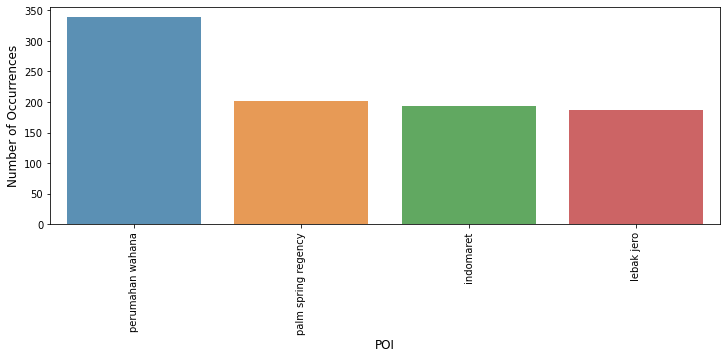

In [15]:
#Display POI
cnt_pro = df_train['POI'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro[1:5].index, cnt_pro[1:5].values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('POI', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Tokenization

In [19]:
train["tokenize"] = df_train["raw_address"].map(lambda x: TextBlob(x).words)
train["tokenizedPOI"] = df_train["POI"].map(lambda x: TextBlob(x).words)
train["tokenizedStreet"] = df_train["street"].map(lambda x: TextBlob(x).words)

test["tokenize"] = df_test["raw_address"].map(lambda x: TextBlob(x).words)

In [20]:
train.head()

,id,raw_address,POI/street,tokenize,tokenizedPOI,tokenizedStreet
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika,"[jl, kapuk, timur, delta, sili, iii, lippo, ci...",[],"[jl, kapuk, timur, delta, sili, iii, lippo, cika]"
1,1,"aye, jati sampurna",/,"[aye, jati, sampurna]",[],[]
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,"[setu, siung, 119, rt, 5, 1, 13880, cipayung]",[],[siung]
3,3,"toko dita, kertosono",toko dita/,"[toko, dita, kertosono]","[toko, dita]",[]
4,4,jl. orde baru,/jl. orde baru,"[jl, orde, baru]",[],"[jl, orde, baru]"


In [21]:
test.head()

,id,raw_address,tokenize
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]"
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]"
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]"
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karan..."
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]"


## Vector Embedding

In [22]:
x = pd.concat([train.tokenize, test.tokenize], axis=0)
x.head()

0    [jl, kapuk, timur, delta, sili, iii, lippo, ci...
1                                [aye, jati, sampurna]
2        [setu, siung, 119, rt, 5, 1, 13880, cipayung]
3                              [toko, dita, kertosono]
4                                     [jl, orde, baru]
Name: tokenize, dtype: object

In [24]:
longest = 0

for _, row in train.iterrows():
    if longest < len(row.tokenize): longest = len(row.tokenize)

print("train max token: ", longest)

longest = 0

for _, row in test.iterrows():
    if longest < len(row.tokenize): longest = len(row.tokenize)

print("test max token: ", longest)

train max token:  32
test max token:  26


## Set Up the Model

In [25]:
#train the model
model = gensim.models.FastText(
    x,
    size=10, 
    window=2, 
    min_count=1, 
    workers=10, 
    sg = 0, 
    iter=100
  )

In [26]:
TRAIN_DATA = []
TRAIN_LABEL = []

for _, row in train.iterrows():
    temp = []
    templabel = []

    count = 0
    for word in row["tokenize"]:
        temp.append(np.array(model[word]))
        count = count + 1
        if(word in row['tokenizedPOI']):
            templabel.append(np.array([1,0,0,0])) # POI 
        elif(word in row['tokenizedStreet']):
            templabel.append(np.array([0,1,0,0])) # street
        else:
            templabel.append(np.array([0,0,1,0])) # not POI or Street

    if(count != 32):
        for i in range(32-count):
            temp.append(np.zeros(10))
            templabel.append(np.zeros(4))

    TRAIN_DATA.append(np.array(temp))
    TRAIN_LABEL.append(np.array(templabel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [27]:
TRAIN_DATA = np.asarray(TRAIN_DATA)
TRAIN_DATA.shape

(300000, 32, 10)

In [28]:
TRAIN_LABEL = np.asarray(TRAIN_LABEL)
TRAIN_LABEL.shape

(300000, 32, 4)

In [29]:
TEST_DATA = []

for _, row in test.iterrows():
    temp = []
    count = 0
    for word in row["tokenize"]:
        temp.append(np.array(model[word]))
        count = count + 1

    if(count != 32):
        for i in range(32-count):
            temp.append(np.zeros(10))

    TEST_DATA.append(np.array(temp))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [30]:
TEST_DATA = np.asarray(TEST_DATA)
TEST_DATA.shape

(50000, 32, 10)

In [31]:
np.save(foldername+"shopee_train_data",TRAIN_DATA )
np.save(foldername+"shopee_train_label",TRAIN_LABEL )
np.save(foldername+"shopee_test_data",TEST_DATA )

## Using the Model

In [32]:
X_train, X_val, y_train, y_val = train_test_split(TRAIN_DATA, TRAIN_LABEL, test_size=0.2)

In [33]:
input_layer = Input(
    shape= (32, 10),
    name='input'
)

dropout_layer = Dropout(0.1)(input_layer)

bilstm_layer = Bidirectional(LSTM(units=100, return_sequences=True))(dropout_layer)

output_layer = TimeDistributed(Dense(4, activation="softmax"))(bilstm_layer)

model = Model(inputs=[input_layer], outputs=[output_layer])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  sample_weight_mode='temporal',
  metrics=['accuracy']
)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 10)]          0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 10)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 200)           88800     
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 4)             804       
Total params: 89,604
Trainable params: 89,604
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(
  x = X_train, 
  y = y_train, 
  validation_data = (X_val, y_val),
  epochs = 25,
  initial_epoch = 0
)

Epoch 1/25
7500/7500 [==============================] - 82s 6ms/step - loss: 0.1065 - accuracy: 0.1743 - val_loss: 0.0850 - val_accuracy: 0.2029
Epoch 2/25
7500/7500 [==============================] - 46s 6ms/step - loss: 0.0885 - accuracy: 0.2353 - val_loss: 0.0816 - val_accuracy: 0.2978
Epoch 3/25
7500/7500 [==============================] - 46s 6ms/step - loss: 0.0855 - accuracy: 0.3983 - val_loss: 0.0801 - val_accuracy: 0.4561
Epoch 4/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0838 - accuracy: 0.4552 - val_loss: 0.0789 - val_accuracy: 0.5249
Epoch 5/25
7500/7500 [==============================] - 46s 6ms/step - loss: 0.0825 - accuracy: 0.4992 - val_loss: 0.0788 - val_accuracy: 0.4233
Epoch 6/25
7500/7500 [==============================] - 46s 6ms/step - loss: 0.0818 - accuracy: 0.4225 - val_loss: 0.0780 - val_accuracy: 0.4802
Epoch 7/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0811 - accuracy: 0.4800 - val_loss: 0.0777 - val_ac

In [37]:
model.save(filepath = foldername+'shopee25epochs.h5')

## Plots

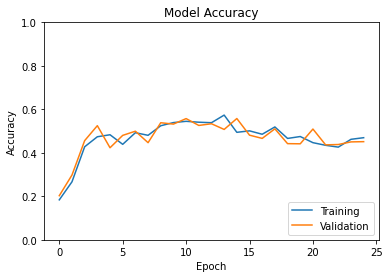

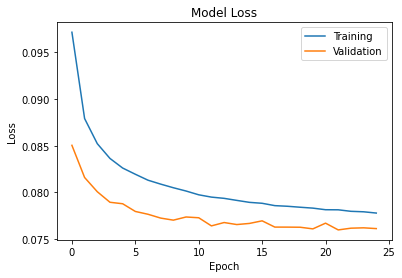

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Model Evaluation

In [39]:
pred = model.predict(TRAIN_DATA)
train["prediction"] = ""

In [40]:
for index, row in train.iterrows():
    street = ""
    POI = ""
    temp = str(np.argmax(pred[index], axis=1)[:len(row.tokenize)]).replace(" ", "").replace("[", "").replace("]", "")
        
    startIndexStreet = temp.index(max(re.findall(r'[1]*', temp), key=len))
    endIndexStreet = startIndexStreet + len(max(re.findall(r'[1]*', temp), key=len))
    startIndexPOI = temp.index(max(re.findall(r'[0]*', temp), key=len))
    endIndexPOI = startIndexPOI + len(max(re.findall(r'[0]*', temp), key=len))

    if(startIndexStreet != endIndexStreet): 
        endStreet = row["raw_address"].find(row["tokenize"][endIndexStreet-1]) + len(row["tokenize"][endIndexStreet-1])
        street = str(row["raw_address"][startIndexStreet:endStreet])

    if(startIndexPOI != endIndexPOI): 
        endPOI = row["raw_address"].find(row["tokenize"][endIndexPOI-1]) + len(row["tokenize"][endIndexPOI-1])
        POI = str(row["raw_address"][startIndexPOI:endPOI])
        
    train.at[index, "prediction"] = str(POI+"/"+street).strip()

In [41]:
train[["POI/street", "prediction"]].head(10)

,POI/street,prediction
0,/jl kapuk timur delta sili iii lippo cika,kapuk timur delta/jl kapuk timur
1,/,/aye
2,/siung,/etu siung
3,toko dita/,toko dita/
4,/jl. orde baru,/jl. orde baru
5,toko bb kids/raya samb gede,"samb gede, 299 toko bb kids/raya samb gede"
6,/kem mel raya,/kem mel raya
7,/tela,/tela keuramat
8,/gg. i,/gg. i
9,/bunga ncole ix,/bunga ncole ix


## Export to CSV

In [42]:
predtest = model.predict(TEST_DATA)
test["POI/street"] = ""

In [43]:
for index, row in test.iterrows():
    street = ""
    POI = ""
    temp = str(np.argmax(pred[index], axis=1)[:len(row.tokenize)]).replace(" ", "").replace("[", "").replace("]", "")
        
    startIndexStreet = temp.index(max(re.findall(r'[1]*', temp), key=len))
    endIndexStreet = startIndexStreet + len(max(re.findall(r'[1]*', temp), key=len))
    startIndexPOI = temp.index(max(re.findall(r'[0]*', temp), key=len))
    endIndexPOI = startIndexPOI + len(max(re.findall(r'[0]*', temp), key=len))

    if(startIndexStreet != endIndexStreet): 
        endStreet = row["raw_address"].find(row["tokenize"][endIndexStreet-1]) + len(row["tokenize"][endIndexStreet-1])
        street = str(row["raw_address"][startIndexStreet:endStreet])

    if(startIndexPOI != endIndexPOI): 
        endPOI = row["raw_address"].find(row["tokenize"][endIndexPOI-1]) + len(row["tokenize"][endIndexPOI-1])
        POI = str(row["raw_address"][startIndexPOI:endPOI])
        
    test.at[index, "POI/street"] = str(POI+"/"+street).strip()

In [44]:
test.head()

,id,raw_address,tokenize,POI/street
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]",par 53 sidanegara/s. par 53
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]",/angg
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]",/sma laun
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karan...",ud agung/
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]","/cut mutia, 35"


In [47]:
outputPath = foldername+"mia_alt_results.csv"
test[["id","POI/street"]].to_csv(outputPath, index = False)